In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import warnings
import os

In [2]:
df = pd.read_csv("./Cleaned_dataset.csv")

df = df.dropna()
df.drop_duplicates(keep='last', ignore_index=True, inplace=True)
df['Date_of_journey'] = pd.to_datetime(df['Date_of_journey'])
df = df.reset_index(drop = True)
df.head()

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5335
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.3333,1,5899
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.1667,1,5801
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5794
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.1667,1,5955


In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df['Journey_day'] = pd.Categorical(df['Journey_day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
ohencode = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
encode = LabelEncoder()

In [4]:
# One Hot encoding the rest of the categorical data
for col in ["Journey_day","Airline","Class", "Source", "Departure", "Total_stops", "Arrival", "Destination"]:
    ohetransform = ohencode.fit_transform(df[[col]])
    df = pd.concat([df, ohetransform], axis=1).drop(columns=[col])

# Label Encoding Flight_code
df.Flight_code = encode.fit_transform(df.Flight_code)

In [5]:
aggregated_df = df.groupby(['Class_Business', 'Class_Economy', 'Class_First',
       'Class_Premium Economy','Date_of_journey', 'Flight_code', 'Airline_Air India',
       'Airline_AirAsia', 'Airline_AkasaAir', 'Airline_AllianceAir',
       'Airline_GO FIRST', 'Airline_Indigo', 'Airline_SpiceJet',
       'Airline_StarAir', 'Airline_Vistara',
       ]).agg(
    total_passengers=('Fare', 'size'),
    average_fare=('Fare', 'mean'),

    Source_Ahmedabad=('Source_Ahmedabad', 'first'),
    Source_Bangalore=('Source_Bangalore', 'first'),
    Source_Chennai=('Source_Chennai', 'first'),
    Source_Delhi=('Source_Delhi', 'first'),
    Source_Hyderabad=('Source_Hyderabad', 'first'),
    Source_Kolkata=('Source_Kolkata', 'first'),
    Source_Mumbai=('Source_Mumbai', 'first'),
    Destination_Ahmedabad=('Destination_Ahmedabad', 'first'),
    Destination_Bangalore=('Destination_Bangalore', 'first'),
    Destination_Chennai=('Destination_Chennai', 'first'),
    Destination_Delhi=('Destination_Delhi', 'first'),
    Destination_Hyderabad=('Destination_Hyderabad', 'first'),
    Destination_Kolkata=('Destination_Kolkata', 'first'),
    Destination_Mumbai=('Destination_Mumbai', 'first'),
    Journey_day_Friday=('Journey_day_Friday', 'first'),
    Journey_day_Monday=('Journey_day_Monday', 'first'),
    Journey_day_Saturday=('Journey_day_Saturday', 'first'),
    Journey_day_Sunday=('Journey_day_Sunday', 'first'),
    Journey_day_Thursday=('Journey_day_Thursday', 'first'),
    Journey_day_Tuesday=('Journey_day_Tuesday', 'first'),
    Journey_day_Wednesday=('Journey_day_Wednesday', 'first'),
    Days_left=('Days_left', 'mean'),
    Arrival_12PM_6PM=('Arrival_12 PM - 6 PM', 'first'),
    Arrival_6AM_12PM=('Arrival_6 AM - 12 PM', 'first'),
    Arrival_After6PM=('Arrival_After 6 PM', 'first'),
    Arrival_Before6AM=('Arrival_Before 6 AM', 'first'),
    Departure_12PM_6PM=('Departure_12 PM - 6 PM', 'first'),
    Departure_6AM_12PM=('Departure_6 AM - 12 PM', 'first'),
    Departure_After6PM=('Departure_After 6 PM', 'first'),
    Departure_Before6AM=('Departure_Before 6 AM', 'first'),
    Duration_in_hours=('Duration_in_hours', 'first'),
    Total_stops_1_stop=('Total_stops_1-stop','first'),
    Total_stops_2plus_stop=('Total_stops_2+-stop','first'),
    Total_stops_non_stop=('Total_stops_non-stop', 'first')
).reset_index()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445366 entries, 0 to 445365
Data columns (total 50 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date_of_journey         445366 non-null  datetime64[ns]
 1   Flight_code             445366 non-null  int64         
 2   Duration_in_hours       445366 non-null  float64       
 3   Days_left               445366 non-null  int64         
 4   Fare                    445366 non-null  int64         
 5   Journey_day_Friday      445366 non-null  float64       
 6   Journey_day_Monday      445366 non-null  float64       
 7   Journey_day_Saturday    445366 non-null  float64       
 8   Journey_day_Sunday      445366 non-null  float64       
 9   Journey_day_Thursday    445366 non-null  float64       
 10  Journey_day_Tuesday     445366 non-null  float64       
 11  Journey_day_Wednesday   445366 non-null  float64       
 12  Airline_Air India       445366

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

models_dict = {}

aggregated_df.sort_values(by='Date_of_journey')

X=aggregated_df.drop(['total_passengers'],axis=1)
y=aggregated_df['total_passengers']

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

X['Duration_in_hours'] = scaler.fit_transform(X[['Duration_in_hours']])
X['Days_left'] = scaler.fit_transform(X[['Days_left']])

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)

X_train

,Class_Business,Class_Economy,Class_First,Class_Premium Economy,Date_of_journey,Flight_code,Airline_Air India,Airline_AirAsia,Airline_AkasaAir,Airline_AllianceAir,...,Arrival_After6PM,Arrival_Before6AM,Departure_12PM_6PM,Departure_6AM_12PM,Departure_After6PM,Departure_Before6AM,Duration_in_hours,Total_stops_1_stop,Total_stops_2plus_stop,Total_stops_non_stop
581,0.0,0.0,0.0,1.0,2023-01-20,1345,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.773354,0.0,0.0,1.0
15483,0.0,1.0,0.0,0.0,2023-01-24,92,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.804302,0.0,0.0,1.0
53240,0.0,1.0,0.0,0.0,2023-02-25,797,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,-0.757861,0.0,0.0,1.0
55634,0.0,1.0,0.0,0.0,2023-02-27,851,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.649505,0.0,0.0,1.0
52362,0.0,1.0,0.0,0.0,2023-02-24,1131,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.695946,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.0,0.0,0.0,1.0,2023-03-06,1394,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.920237,1.0,0.0,0.0
54886,0.0,1.0,0.0,0.0,2023-02-26,1353,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.223619,1.0,0.0,0.0
76820,1.0,0.0,0.0,0.0,2023-03-04,1249,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.432773,1.0,0.0,0.0
860,0.0,0.0,0.0,1.0,2023-01-22,1396,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,-0.788828,0.0,0.0,1.0


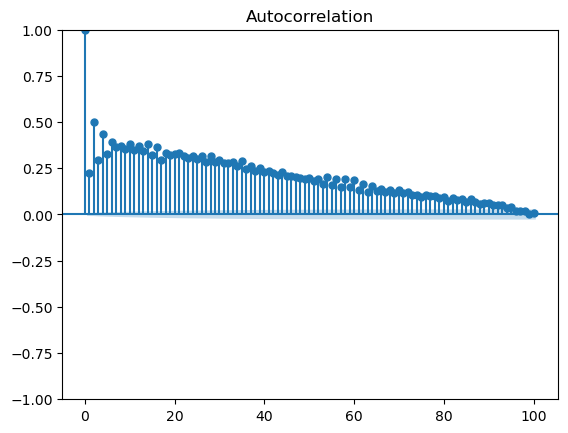

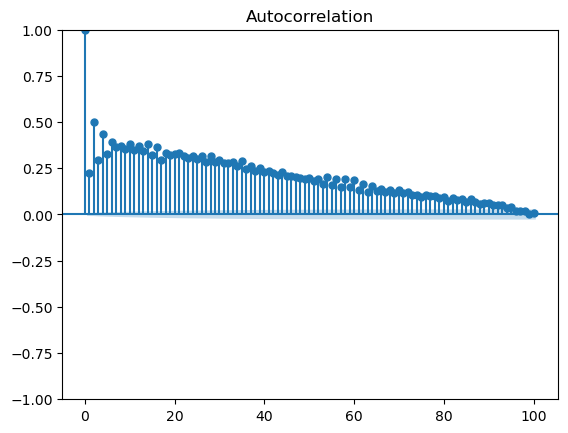

In [8]:
# subset = passengers_df
subset = aggregated_df[aggregated_df["Class_Economy"] == 1]
# subset = subset[subset["Airline"] == 0]
plot_acf(subset['total_passengers'], lags=100)

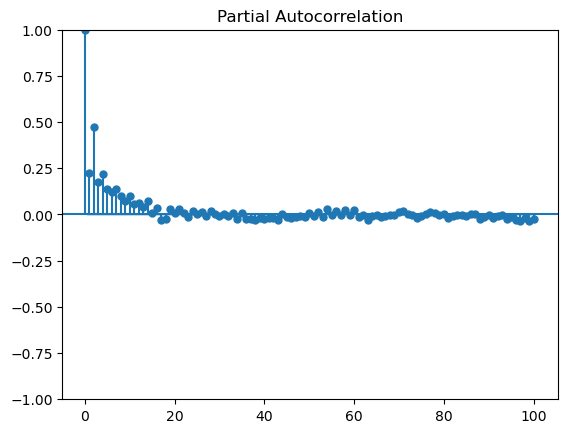

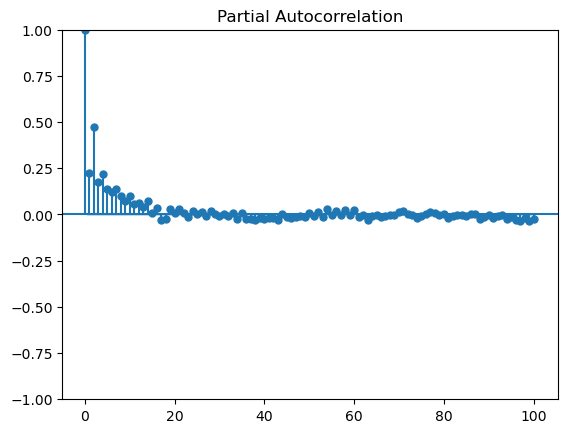

In [9]:
plot_pacf(subset['total_passengers'], lags=100)

In [10]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

dict = {}

result = adfuller(subset['total_passengers'])
dict["Results"] = (result[0], result[1])

'''except ValueError as e:
        print(f"ValueError for {destination}: {e}")
        dict[destination] = (None, None)'''

results_df = pd.DataFrame(dict).T
results_df.columns = ["ADF Statistic", "p-value"]

results_df

,ADF Statistic,p-value
Results,-18.58711,2.075196e-30


In [11]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
import pmdarima as pm

In [ ]:
# this will crash my jupyter server, so i will do it locally
model = pm.auto_arima(subset['total_passengers'], seasonal=True, trace=True)
print(model.summary())

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

y = subset['total_passengers']
print (y.shape)


# Split the df into train and test
train_size = int(len(subset) * 0.8)

train = y[0:train_size]
test = y[train_size:len(subset)]

# Fit the ARIMA model on the training dataset
model = SARIMAX(subset['total_passengers'], order=(2, 1, 3))
model_fit = model.fit()
# print(model_fit.summary())
if model_fit:
    print("Model fitting successful.")

(57908,)


/home/prab/miniconda3/envs/islp2/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/prab/miniconda3/envs/islp2/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90535D+00    |proj g|=  1.57823D-02


 This problem is unconstrained.



At iterate    5    f=  2.90432D+00    |proj g|=  7.69798D-03

At iterate   10    f=  2.90410D+00    |proj g|=  3.38692D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     13      1     0     0   2.437D-05   2.904D+00
  F =   2.9040994556345363     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model fitting successful.


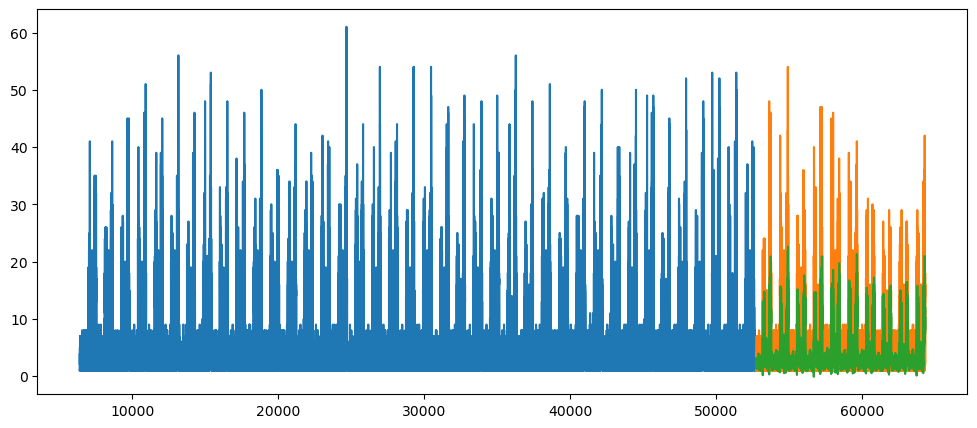

In [14]:
start = train_size  # Example start point for in-sample predictions
end = len(subset) - 1  # Example end point for in-sample predictions
predictions = model_fit.predict(start=start, end=end, dynamic=False)

plt.figure(figsize=(12,5))
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predictions')

In [15]:
def RMSE (y_test, y_pred):
    return np.sqrt(np.mean((y_test - y_pred) ** 2))

def MAPE (y_test, y_pred):
        y_test, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {RMSE(test, predictions)}")
print(f"MAPE: {MAPE(test, predictions)}")

models_dict["SARIMAX"] = [model, RMSE(test, predictions), MAPE(test, predictions)]

RMSE: 4.204959166910693
MAPE: 98.86820457679285


<Figure size 2000x800 with 0 Axes>

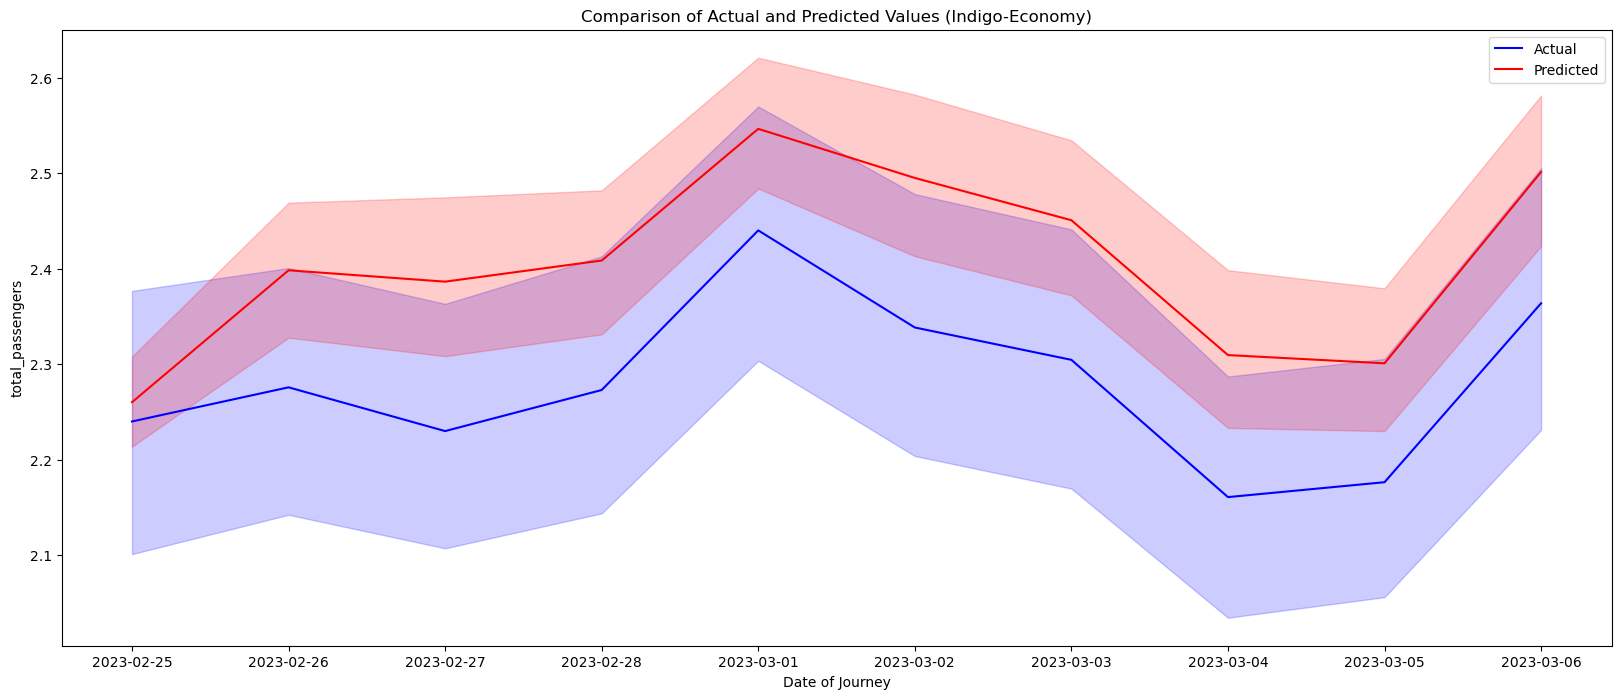

In [18]:
out=pd.DataFrame({'demand_actual':test,'demand_pred':predictions})
result=aggregated_df.merge(out,left_index=True,right_index=True)

airline_df = result[result['Airline_Indigo']==1]
airline_df = airline_df[airline_df['Class_Economy']==1]

plt.figure(figsize=(20,8))
plt.figure(figsize=(20,8))
sns.lineplot(data=airline_df, x='Date_of_journey', y='demand_actual', label='Actual', color='blue')
sns.lineplot(data=airline_df, x='Date_of_journey', y='demand_pred', label='Predicted', color='red')
plt.xlabel('Date of Journey')
plt.ylabel('total_passengers')
plt.title('Comparison of Actual and Predicted Values (Indigo-Economy)')
plt.legend()
plt.show()

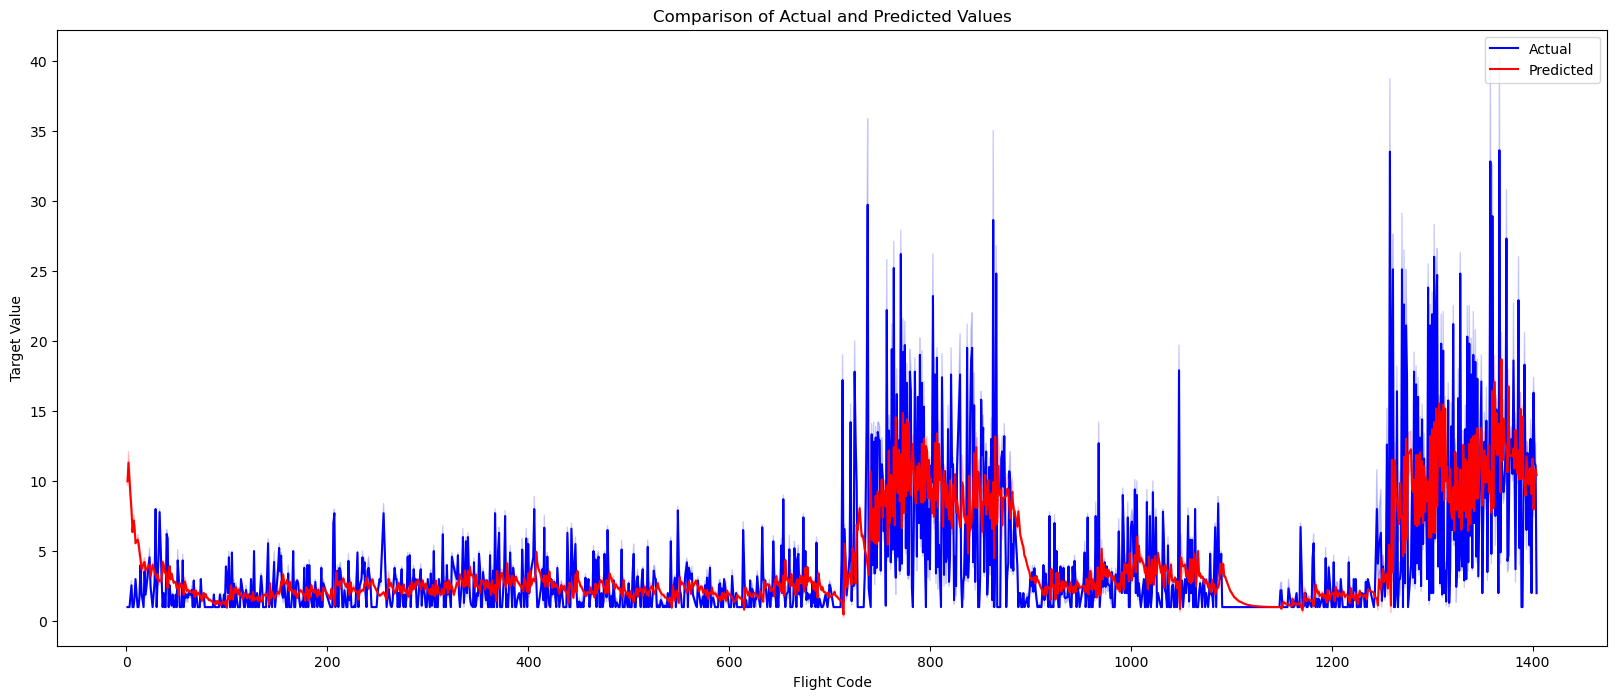

In [19]:
plt.figure(figsize=(20,8))
sns.lineplot(data=result, x='Flight_code', y='demand_actual', label='Actual', color='blue')
sns.lineplot(data=result, x='Flight_code', y='demand_pred', label='Predicted', color='red')
plt.xlabel('Flight Code')
plt.ylabel('Target Value')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

In [20]:
from sklearn.ensemble import RandomForestRegressor

X = subset.drop(['total_passengers', "Date_of_journey"], axis=1)
y = subset['total_passengers']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

print(f"RMSE: {RMSE(y_test, y_preds)}")
print(f"MAPE: {MAPE(y_test, y_preds)}")

models_dict["RandomForestRegressor"] = [model, RMSE(y_test, y_preds), MAPE(y_test, y_preds)]

RMSE: 1.3077922390402346
MAPE: 13.914447644324781


<Figure size 2000x800 with 0 Axes>

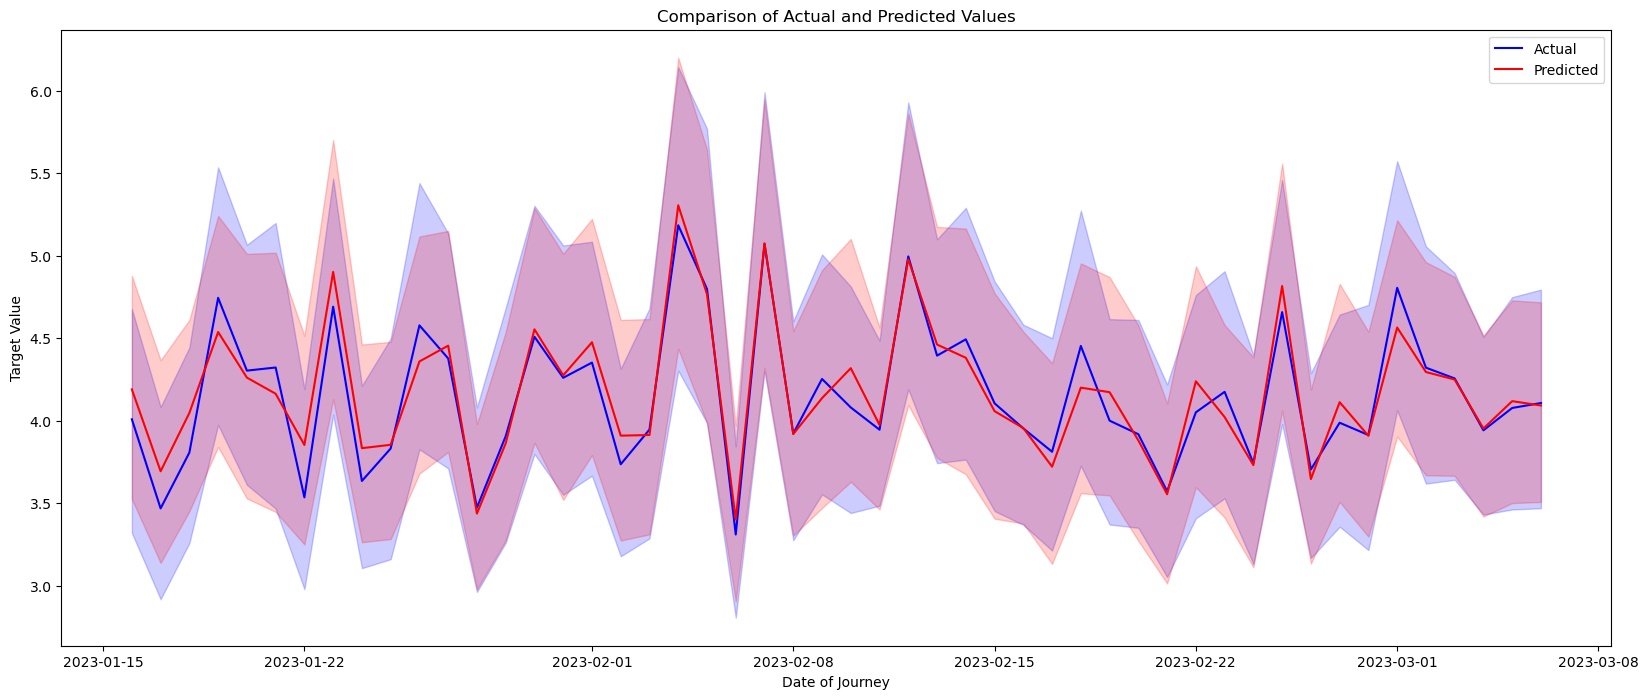

In [21]:
out=pd.DataFrame({'demand_actual':y_test,'demand_pred':y_preds})
result= subset.merge(out,left_index=True,right_index=True)

plt.figure(figsize=(20,8))
plt.figure(figsize=(20,8))
sns.lineplot(data=result, x='Date_of_journey', y='demand_actual', label='Actual', color='blue')
sns.lineplot(data=result, x='Date_of_journey', y='demand_pred', label='Predicted', color='red')
plt.xlabel('Date of Journey')
plt.ylabel('Target Value')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

<Figure size 2000x800 with 0 Axes>

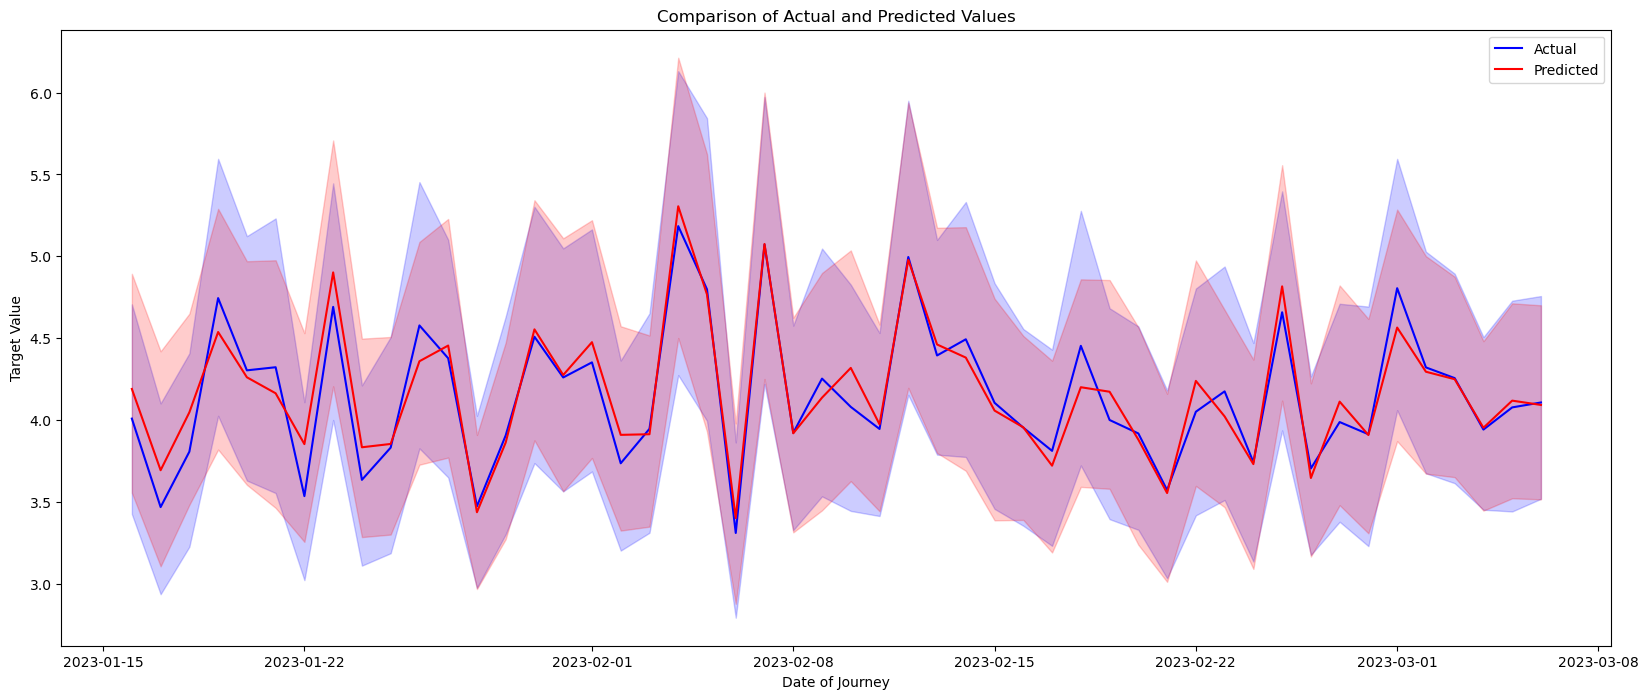

In [22]:
plt.figure(figsize=(20,8))
plt.figure(figsize=(20,8))
sns.lineplot(data=result, x='Date_of_journey', y='demand_actual', label='Actual', color='blue')
sns.lineplot(data=result, x='Date_of_journey', y='demand_pred', label='Predicted', color='red')
plt.xlabel('Date of Journey')
plt.ylabel('Target Value')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

/home/prab/miniconda3/envs/islp2/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


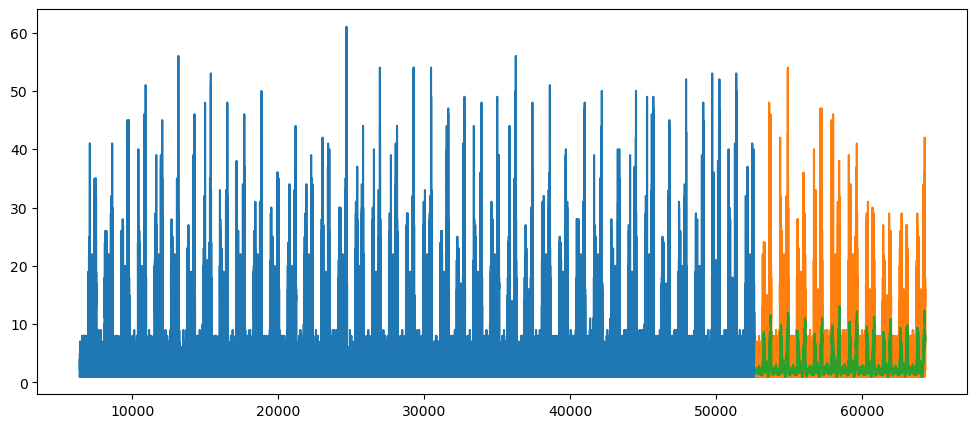

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(subset['total_passengers'], seasonal='add', seasonal_periods=7, use_boxcox = 0.01)

model_fit = model.fit()

predictions = model_fit.predict(start=train_size, end=len(subset)-1)

plt.figure(figsize=(12,5))

plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predictions')

In [24]:

print(f"RMSE: {RMSE(test, predictions)}")
print(f"MAPE: {MAPE(test, predictions)}")

models_dict["HoltWinters"] = [model, RMSE(test, predictions), MAPE(test, predictions)]

RMSE: 4.607867942905803
MAPE: 71.94428790543823


<Figure size 2000x800 with 0 Axes>

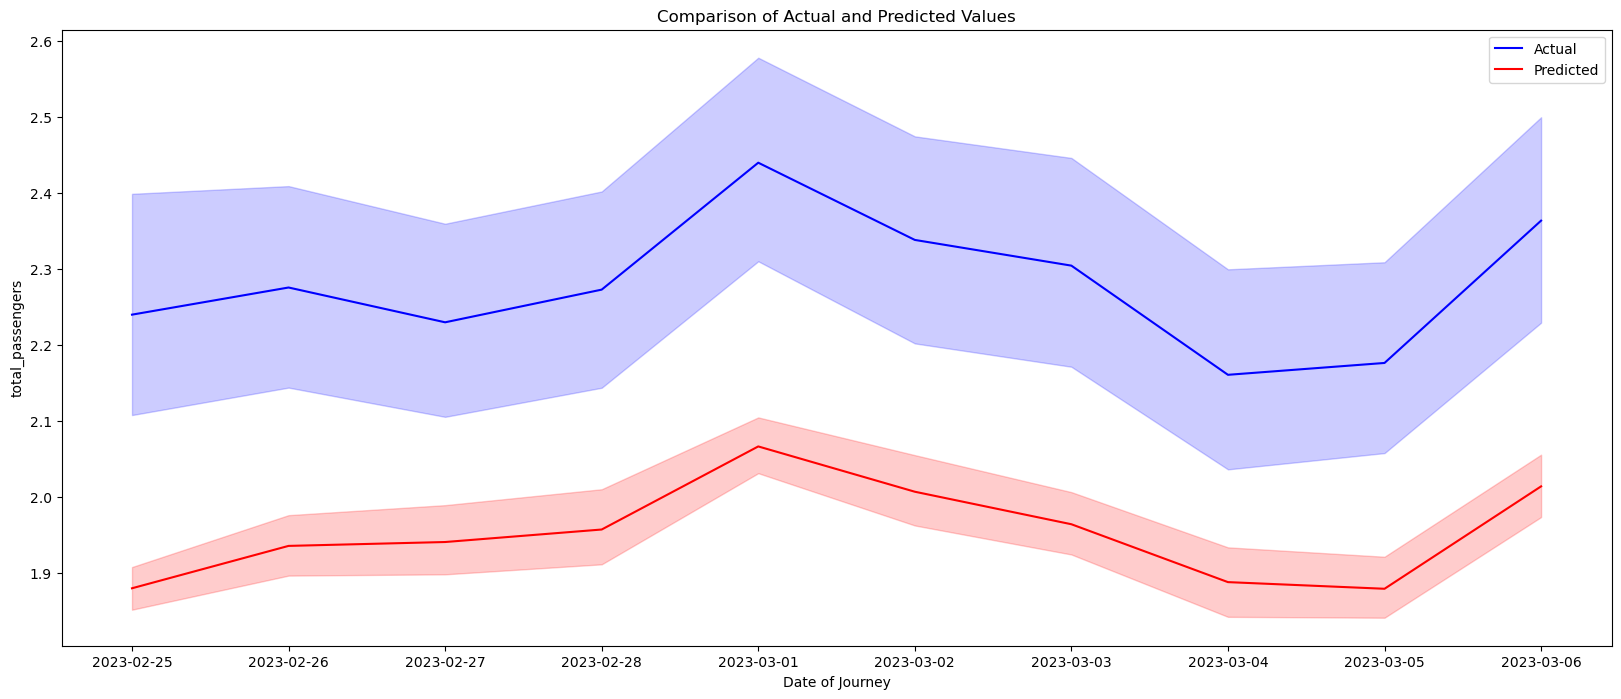

In [26]:
out=pd.DataFrame({'demand_actual':test,'demand_pred':predictions})
result=aggregated_df.merge(out,left_index=True,right_index=True)

airline_df = result[result['Airline_Indigo']==1]
airline_df = airline_df[airline_df['Class_Economy']==1]

plt.figure(figsize=(20,8))
plt.figure(figsize=(20,8))
sns.lineplot(data=airline_df, x='Date_of_journey', y='demand_actual', label='Actual', color='blue')
sns.lineplot(data=airline_df, x='Date_of_journey', y='demand_pred', label='Predicted', color='red')
plt.xlabel('Date of Journey')
plt.ylabel('total_passengers')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

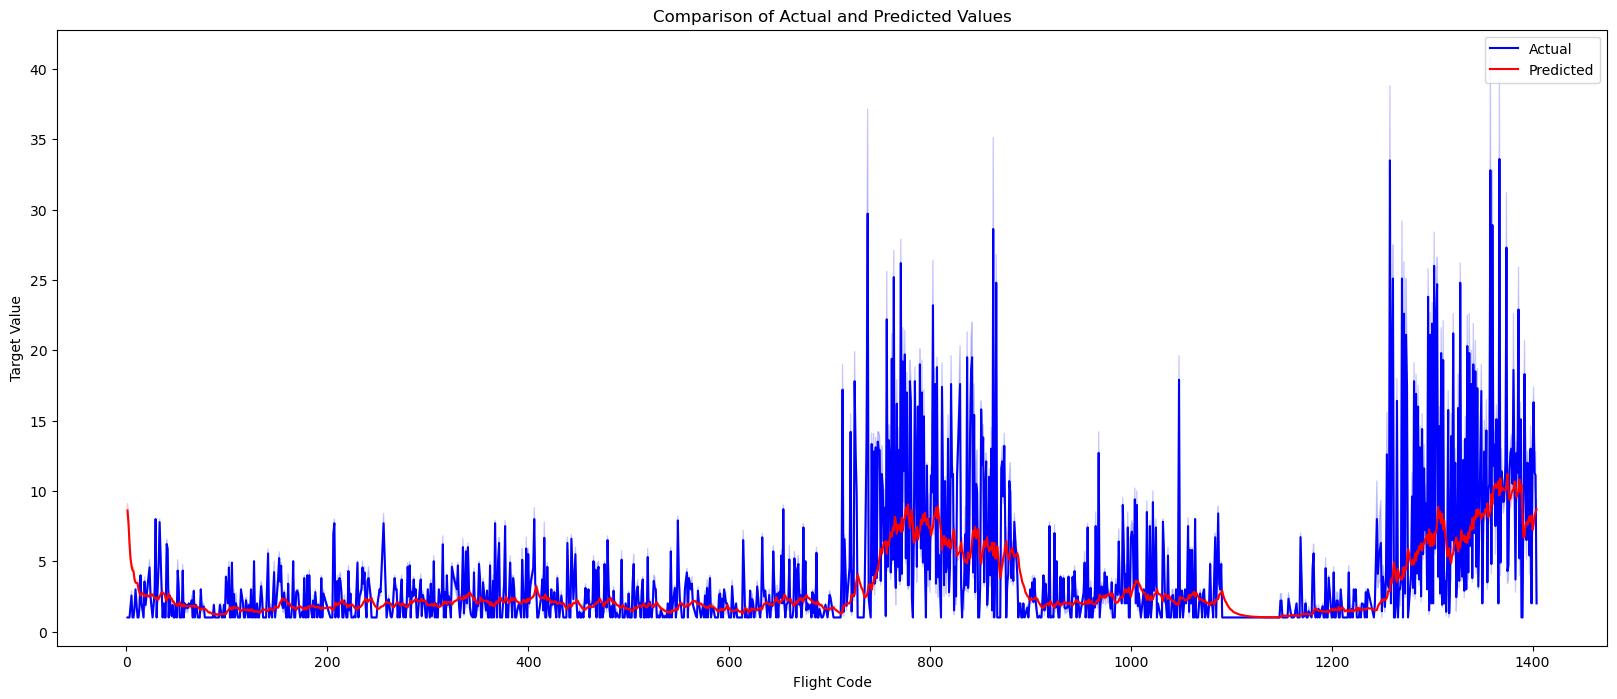

In [27]:
plt.figure(figsize=(20,8))
sns.lineplot(data=result, x='Flight_code', y='demand_actual', label='Actual', color='blue')
sns.lineplot(data=result, x='Flight_code', y='demand_pred', label='Predicted', color='red')
plt.xlabel('Flight Code')
plt.ylabel('Target Value')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

In [28]:
models_df = pd.DataFrame(models_dict).T
models_df.columns = ["Model", "RMSE", "MAPE"]
models_df

,Model,RMSE,MAPE
SARIMAX,<statsmodels.tsa.statespace.sarimax.SARIMAX ob...,4.204959,98.868205
RandomForestRegressor,"(DecisionTreeRegressor(max_features=1.0, rando...",1.307792,13.914448
HoltWinters,<statsmodels.tsa.holtwinters.model.Exponential...,4.607868,71.944288
